## Statistical test for the simulated data

In [1]:
import sys
from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from MMAR.MMAR import MMAR
from utility_functions import (
    compare_qq_plots,
    compare_return_distribution,
    get_standard_returns,
    plot_ks_comparison,
    plot_multiple_return_comparison,
)

In [3]:
import warnings

import numpy as np
import pandas as pd
import scipy.stats as st
from tqdm.notebook import trange

warnings.filterwarnings("ignore")

In [4]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)
spy = spy.loc[:"2018-01-02",]
spy

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,121.559998,121.760002,119.900002,120.300003,83.623352,55748000
2005-01-04,120.459999,120.540001,118.440002,118.830002,82.601585,69167600
2005-01-05,118.739998,119.250000,118.000000,118.010002,82.031548,65667300
2005-01-06,118.440002,119.150002,118.260002,118.610001,82.448624,47814700
2005-01-07,118.970001,119.230003,118.129997,118.440002,82.330460,55847700
...,...,...,...,...,...,...
2017-12-26,267.049988,267.440002,266.890015,267.190002,241.643372,45244400
2017-12-27,267.380005,267.730011,267.010010,267.320007,241.760895,57751000
2017-12-28,267.890015,267.920013,267.450012,267.869995,242.258301,45116100


In [5]:
interval = 126  # 6 months
S0 = spy.iloc[-interval]["Close"]
print(S0)

242.7700042724609


In [6]:
mmar = MMAR(spy["Close"], volume=spy["Volume"])

The series has been adjusted: the orginal size was 3273, the new size is 3272 with 6 dividers.


In [7]:
sim = mmar.get_MMAR_MC(S0, interval, 100_000)

In [8]:
# Get normalized log returns form original data
norm_log_returns = get_standard_returns(spy.iloc[-interval:,]["Close"])

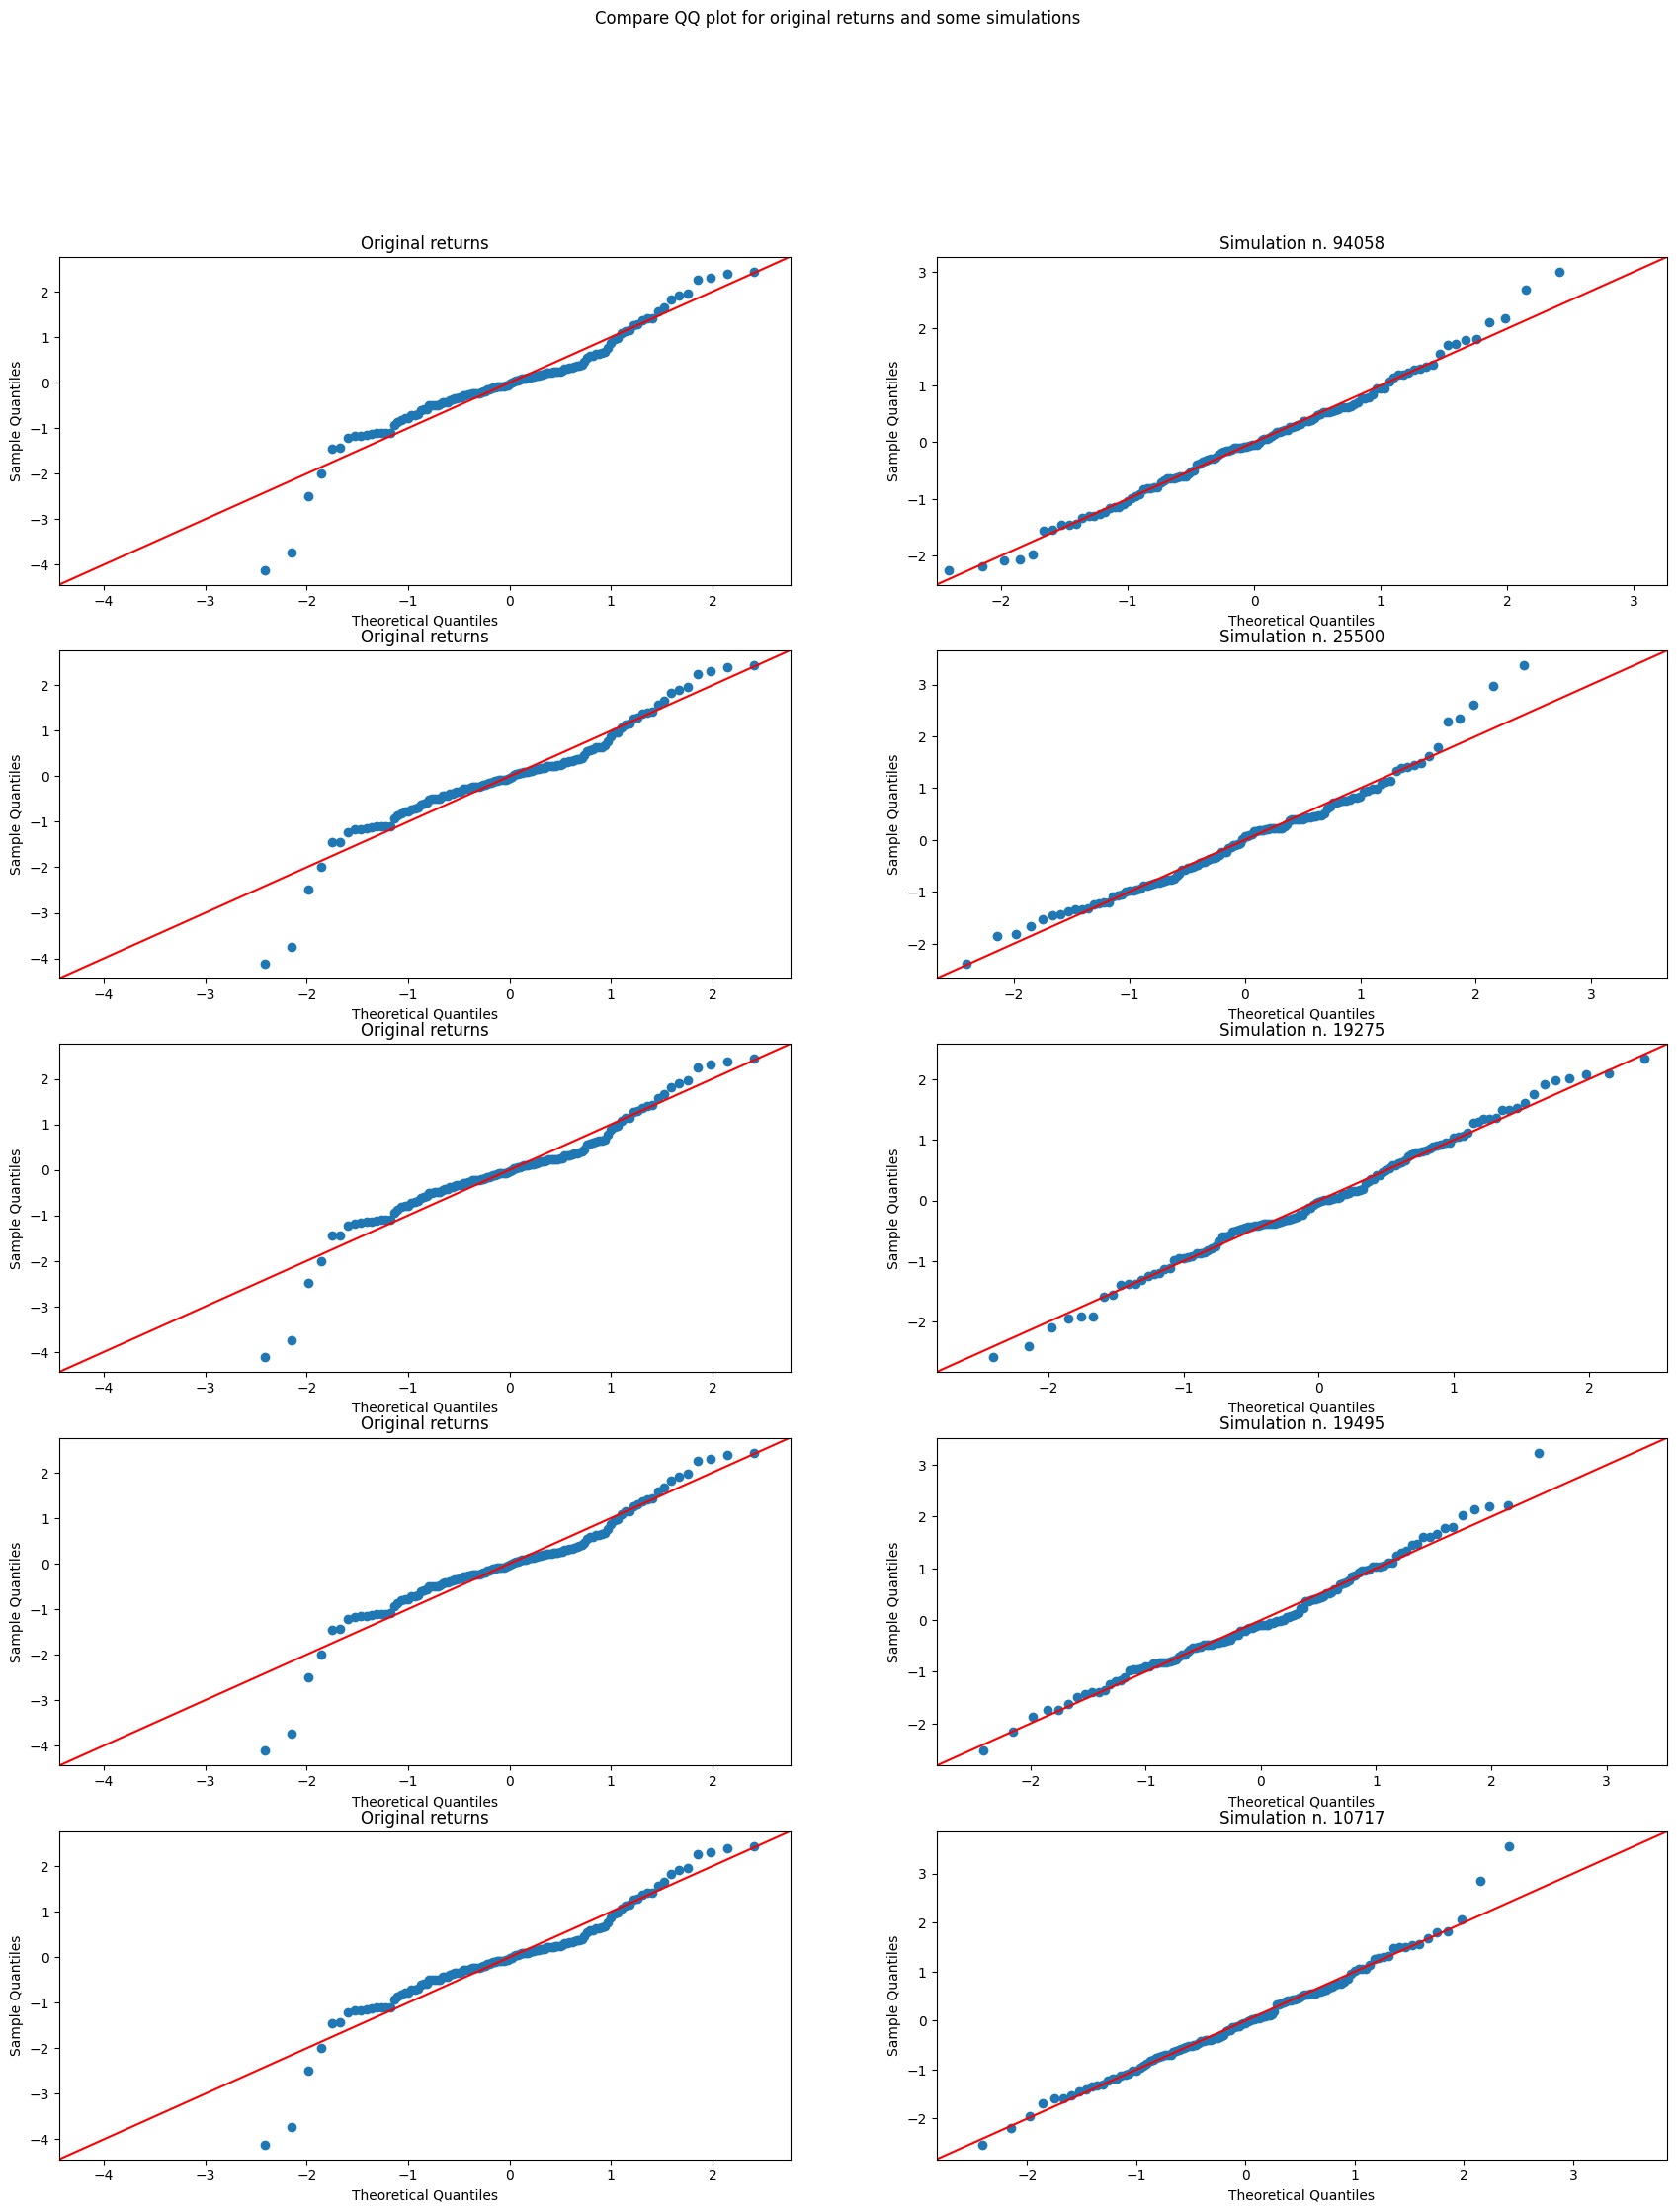

In [9]:
compare_qq_plots(spy, sim, interval)

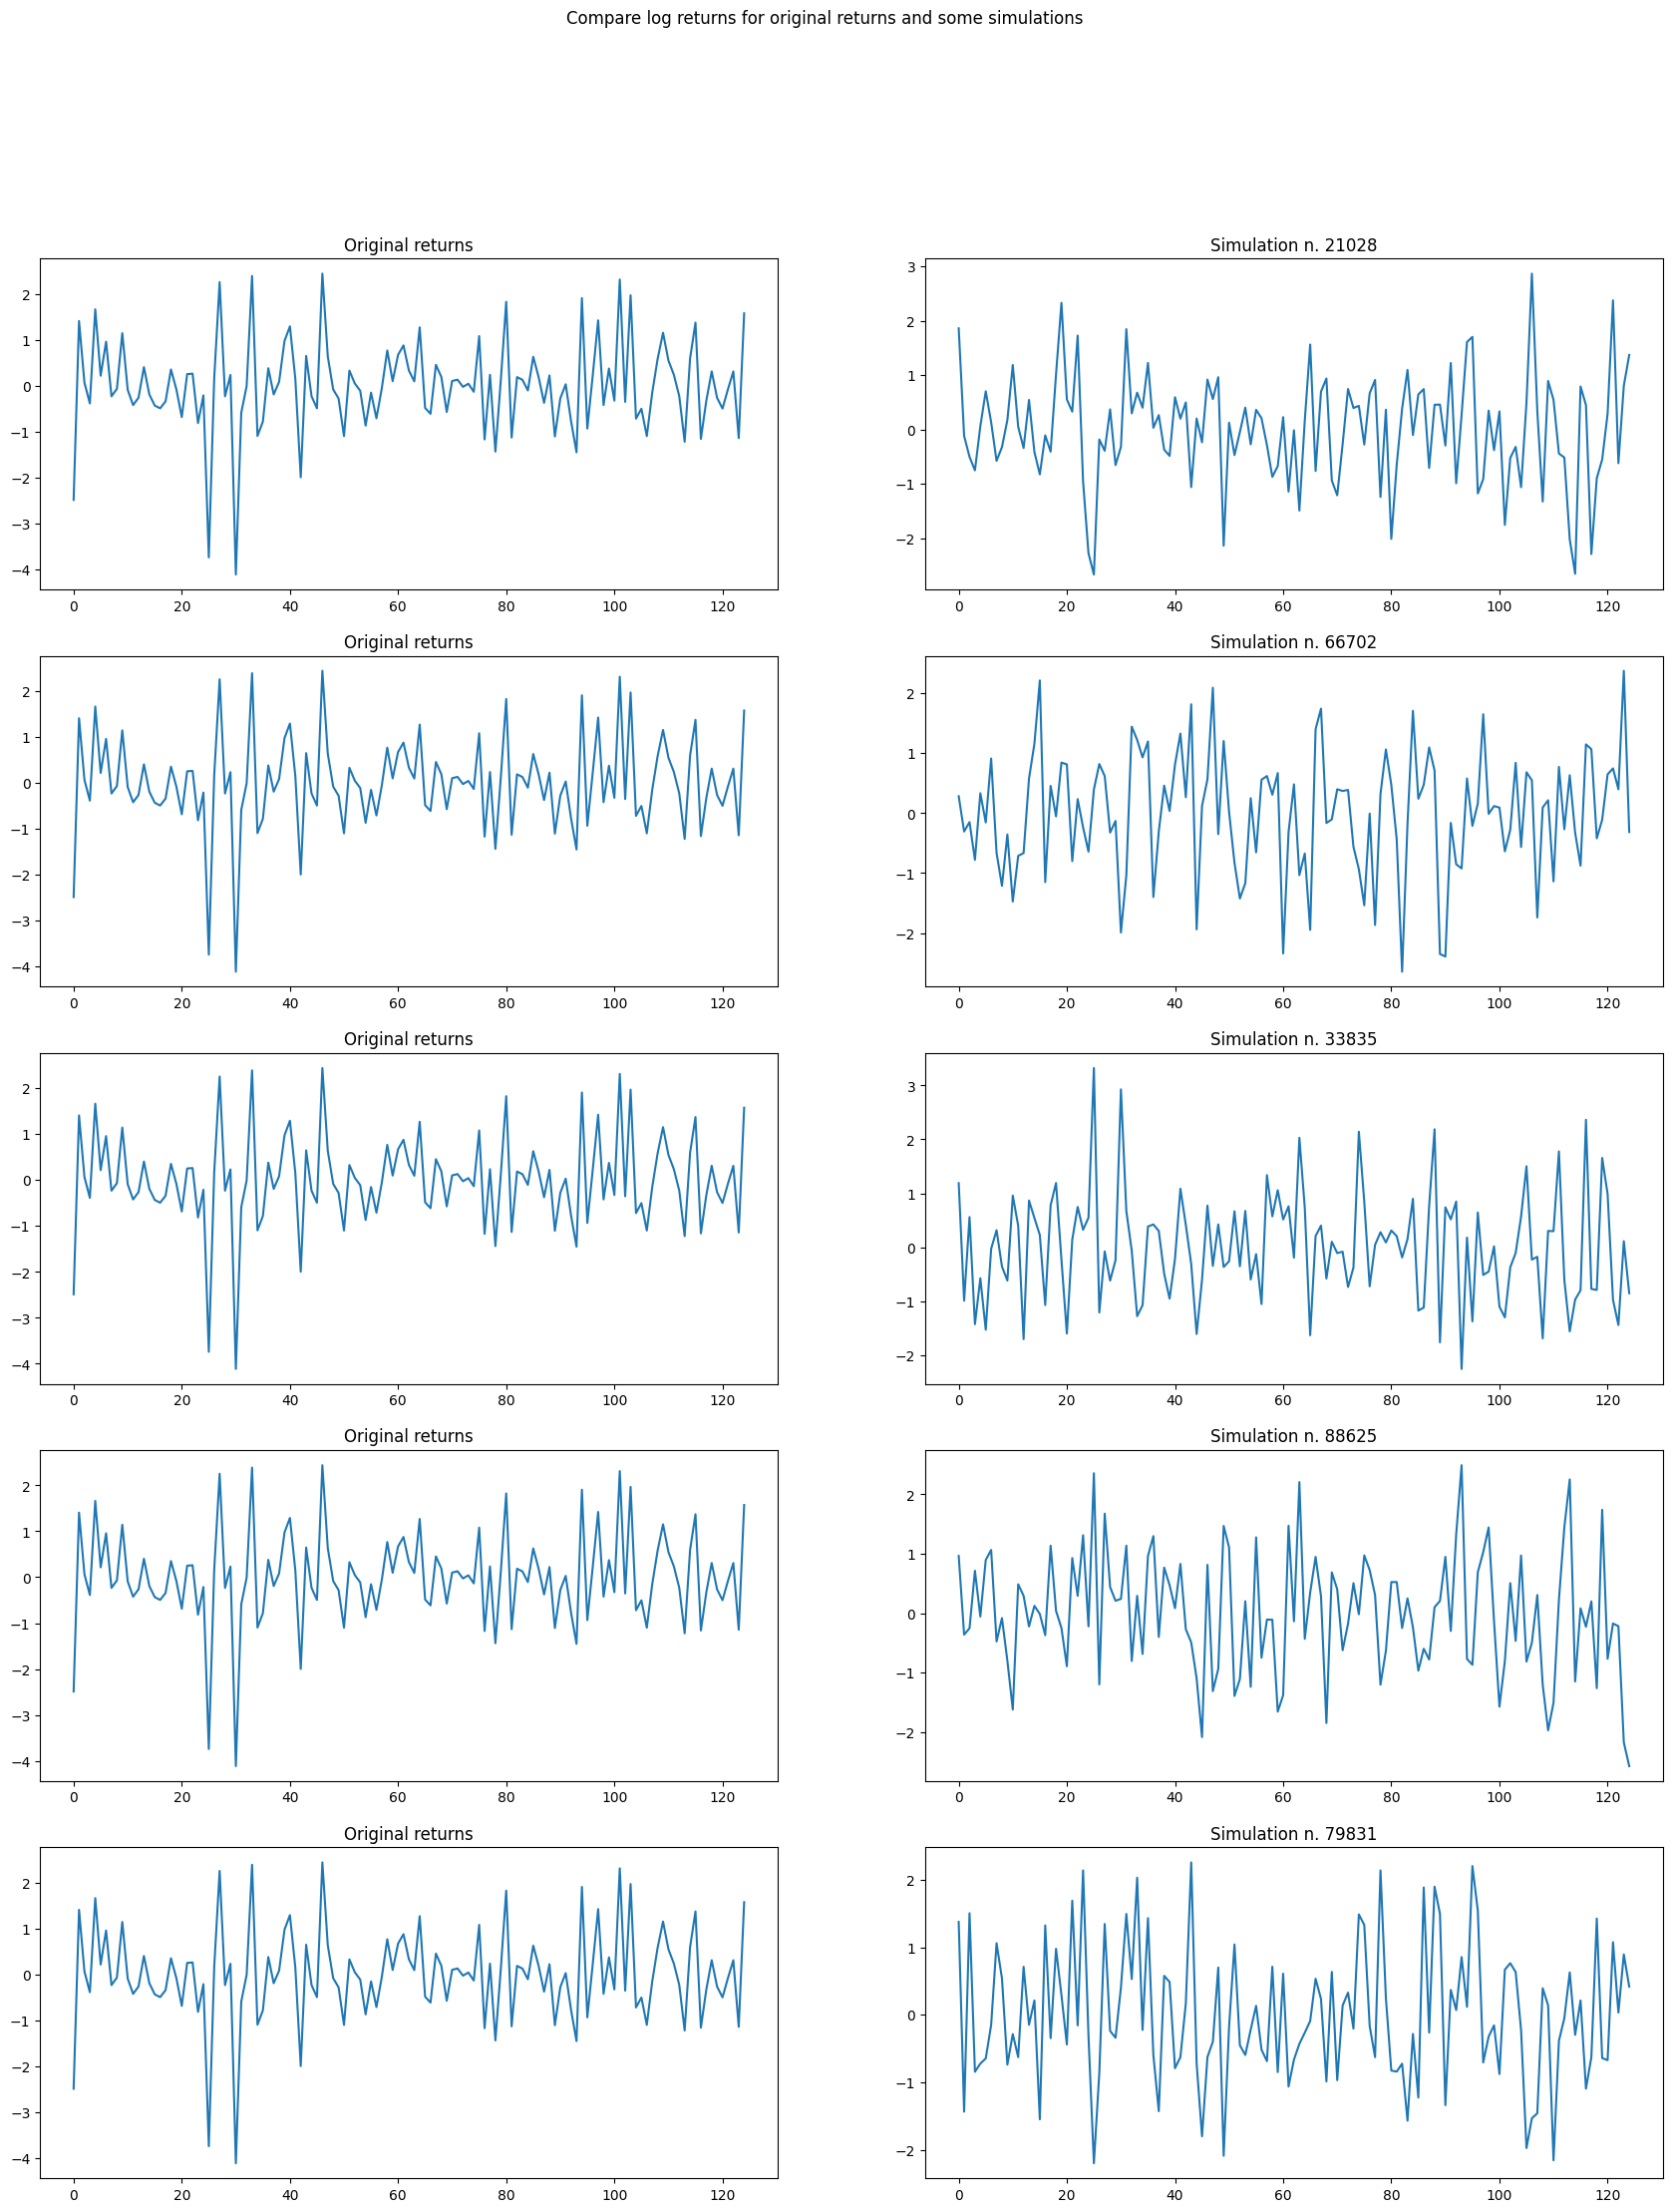

In [10]:
plot_multiple_return_comparison(spy, sim, interval)

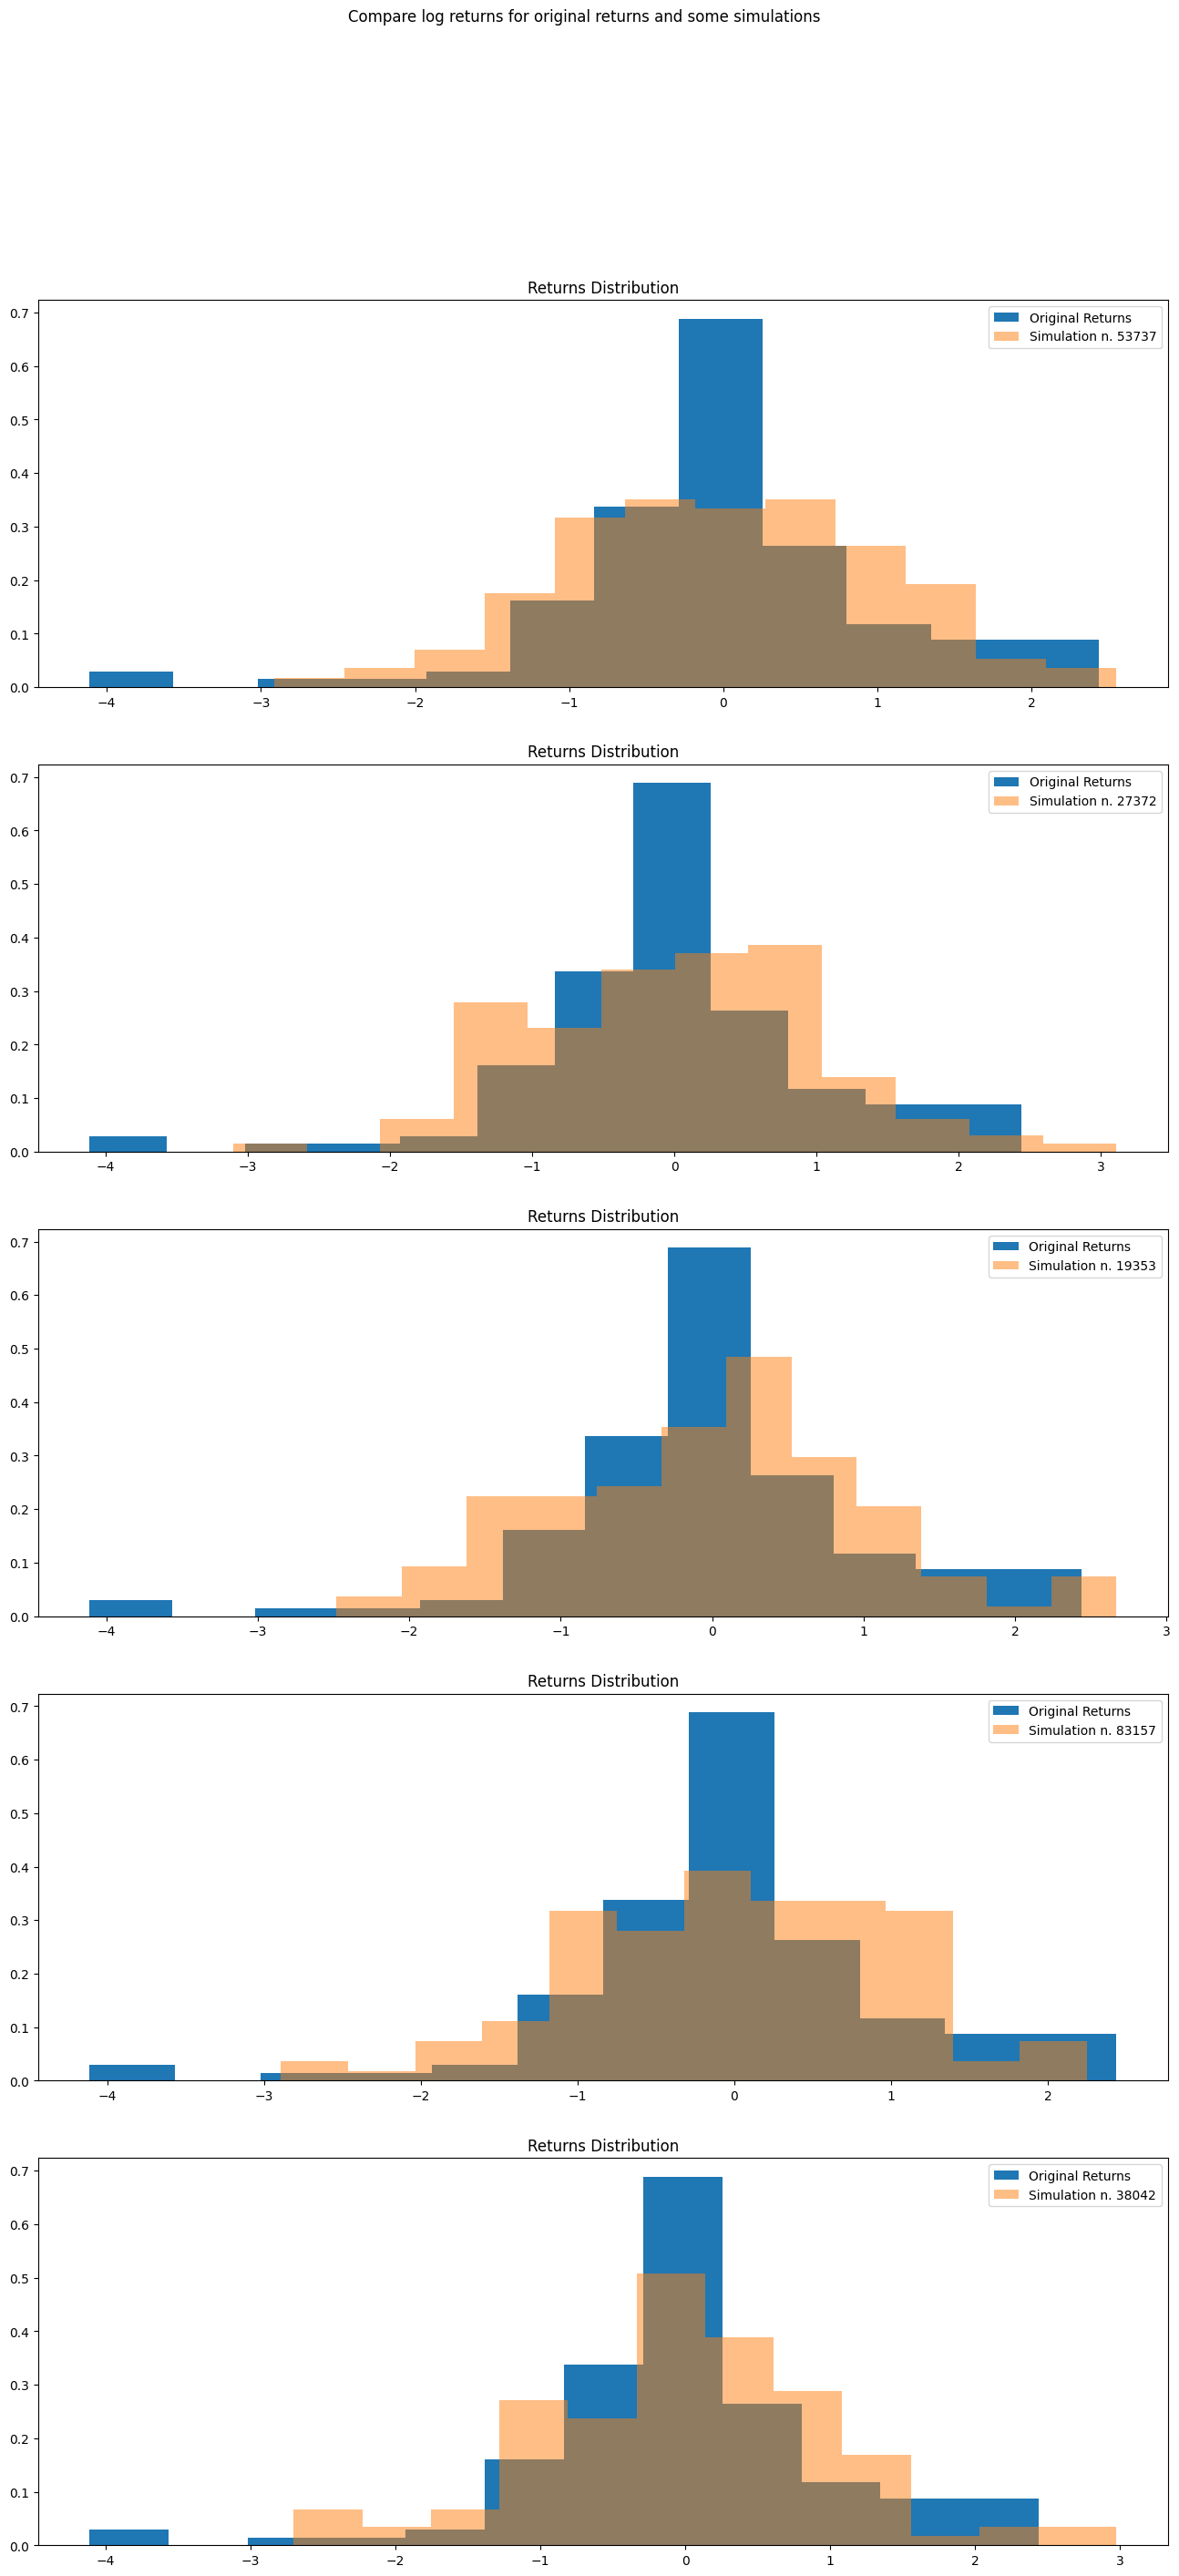

In [11]:
compare_return_distribution(spy, sim, interval)

### Compute skewness and kurtosis for the simulated data

In [12]:
kurtosis_values = []
skew_values = []
for i in trange(len(sim)):
    norm_val = get_standard_returns(sim[i,])
    kurtosis_values.append(st.kurtosis(norm_val))
    skew_values.append(st.skew(norm_val))
kurtosis_values = pd.Series(kurtosis_values)
skew_values = pd.Series(skew_values)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [13]:
kurtosis_values.describe()

count    100000.000000
mean          0.286308
std           0.645531
min          -1.012411
25%          -0.137416
50%           0.158319
75%           0.558545
max           8.933881
dtype: float64

In [14]:
skew_values.describe()

count    100000.000000
mean         -0.001259
std           0.271285
min          -1.929328
25%          -0.173822
50%          -0.001231
75%           0.170596
max           1.867123
dtype: float64

### Compute skewness and kurtosis for the original data in chunks of `interval`

In [15]:
kurtosis_values = []
skew_values = []
for i in trange(len(spy), interval, -interval):
    sim_ex = get_standard_returns(spy.iloc[i - interval : i]["Close"])
    kurtosis_values.append(st.kurtosis(sim_ex))
    skew_values.append(st.skew(sim_ex))
kurtosis_values = pd.Series(kurtosis_values)
skew_values = pd.Series(skew_values)

  0%|          | 0/25 [00:00<?, ?it/s]

In [16]:
kurtosis_values.describe()

count    25.000000
mean      1.364864
std       1.316703
min      -0.146486
25%       0.630457
50%       1.028132
75%       1.624192
max       6.167635
dtype: float64

In [17]:
skew_values.describe()

count    25.000000
mean     -0.249247
std       0.400992
min      -1.402474
25%      -0.387093
50%      -0.198320
75%       0.047491
max       0.332753
dtype: float64

###  Compare simulated data with original log returns

In [18]:
kstest_values = []
for i in trange(len(sim)):
    norm_val = get_standard_returns(sim[i,])
    kstest_values.append(st.kstest(norm_val, norm_log_returns)[1] > 0.05)

  0%|          | 0/100000 [00:00<?, ?it/s]

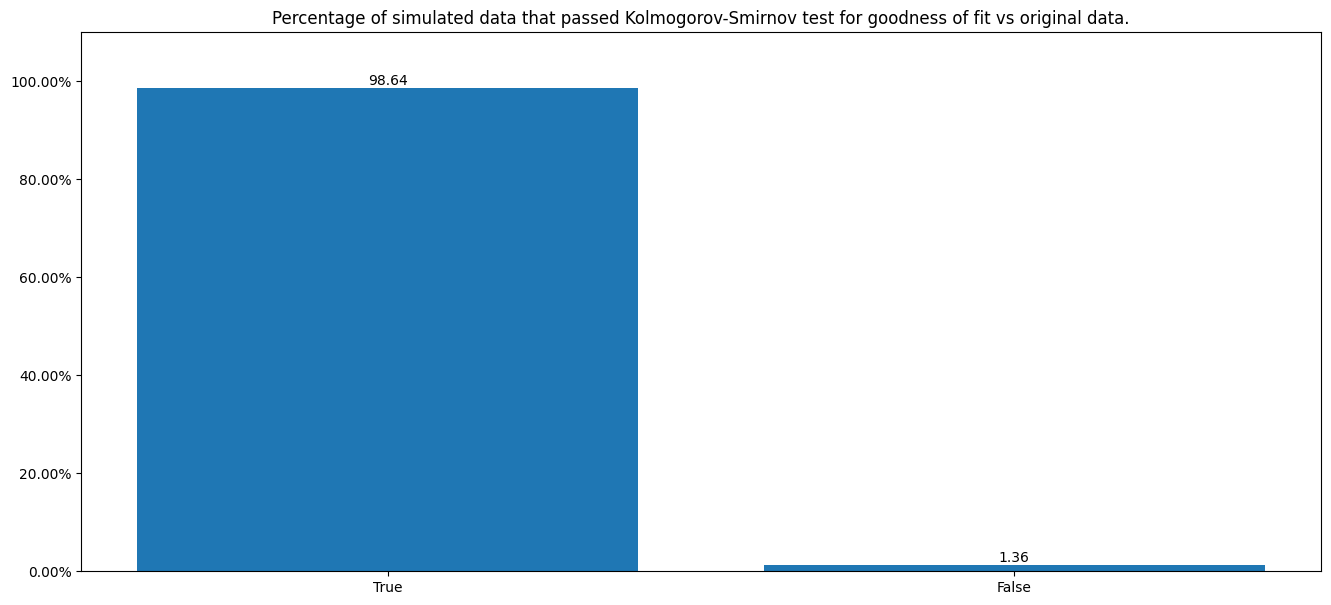

In [19]:
plot_ks_comparison(
    kstest_values,
    "Percentage of simulated data that passed Kolmogorov-Smirnov test for goodness of fit vs original data.",
)

### Compare simulated data with lognormal distribution


In [20]:
kstest_values = []
rnd_log_normal = np.random.lognormal(size=interval)
for i in trange(len(sim)):
    norm_val = get_standard_returns(sim[i,])
    kstest_values.append(st.kstest(norm_val, rnd_log_normal)[1] > 0.05)

  0%|          | 0/100000 [00:00<?, ?it/s]

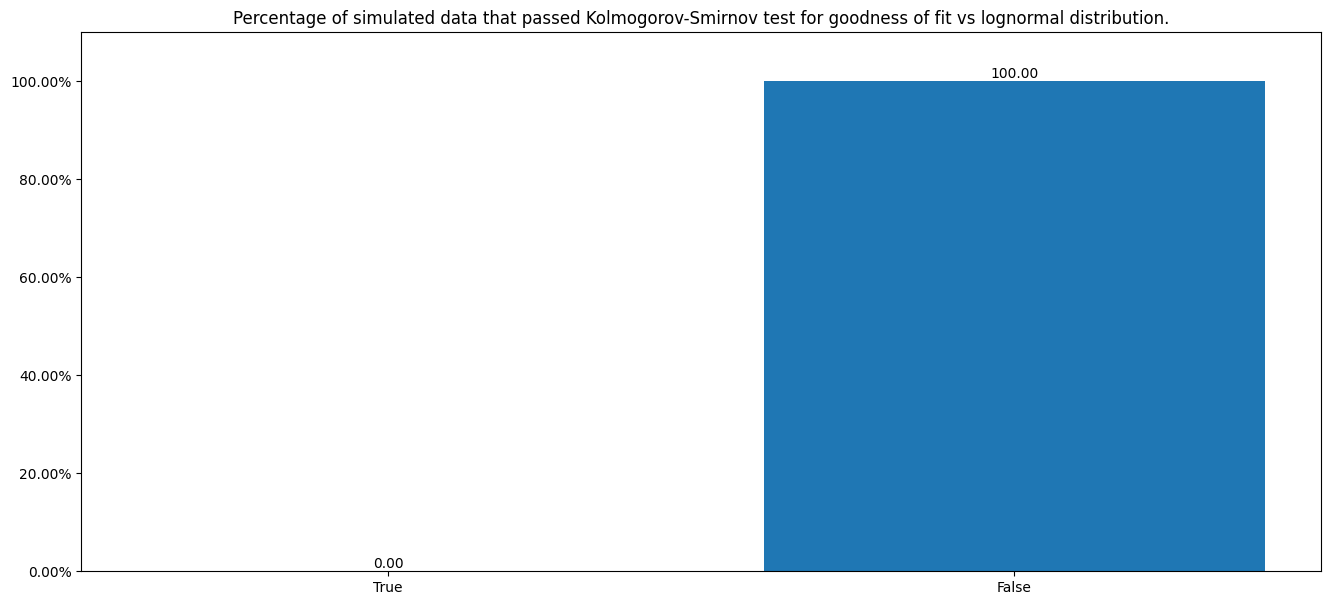

In [21]:
plot_ks_comparison(
    kstest_values,
    "Percentage of simulated data that passed Kolmogorov-Smirnov test for goodness of fit vs lognormal distribution.",
)

### Compare simulated data with normal distribution

In [22]:
kstest_values = []
rnd_normal = np.random.normal(size=interval)
for i in trange(len(sim)):
    norm_val = get_standard_returns(sim[i,])
    kstest_values.append(st.kstest(norm_val, rnd_normal)[1] > 0.05)

  0%|          | 0/100000 [00:00<?, ?it/s]

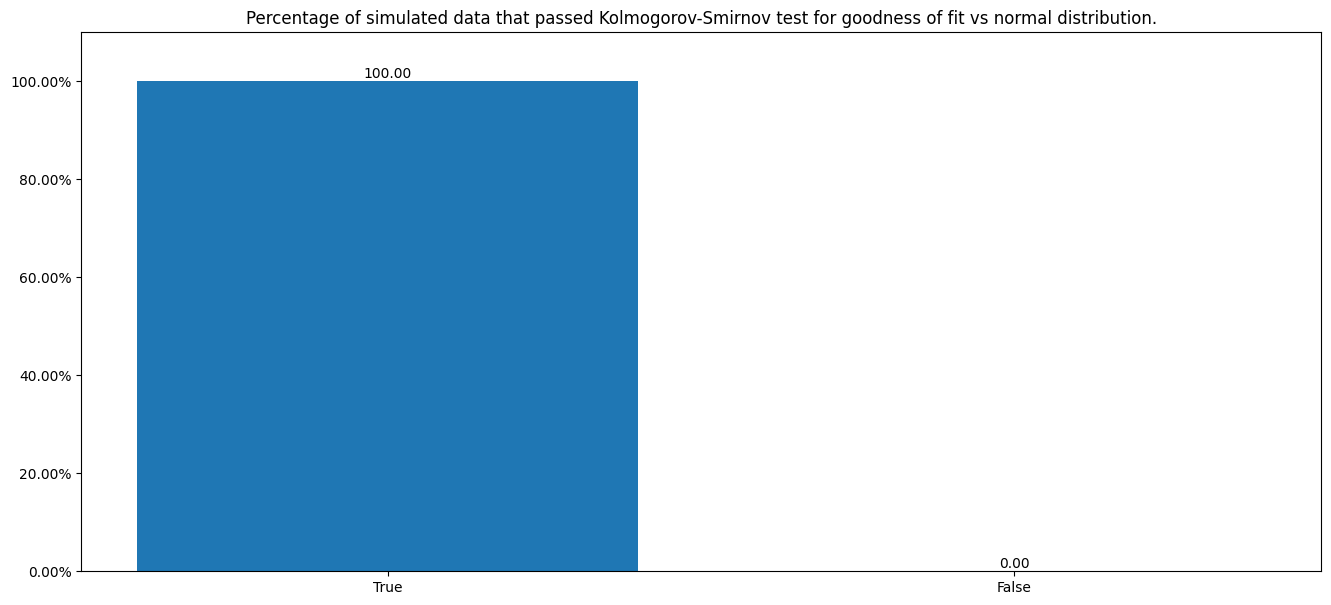

In [23]:
plot_ks_comparison(
    kstest_values,
    "Percentage of simulated data that passed Kolmogorov-Smirnov test for goodness of fit vs normal distribution.",
)

### Compare original log returns with normal distribution

In [24]:
rnd_normal = np.random.normal(size=interval)
print(
    f"The original log return distributions is Normal: {st.kstest(norm_log_returns, rnd_normal)[1] > 0.05}"
)

The original log return distributions is Normal: True


In [25]:
kstest_values = []
for i in trange(len(spy), interval, -interval):
    sim_ex = spy.iloc[i - interval : i]["Close"]
    kstest_values.append(st.kstest(get_standard_returns(sim_ex), rnd_normal)[1] > 0.05)

  0%|          | 0/25 [00:00<?, ?it/s]

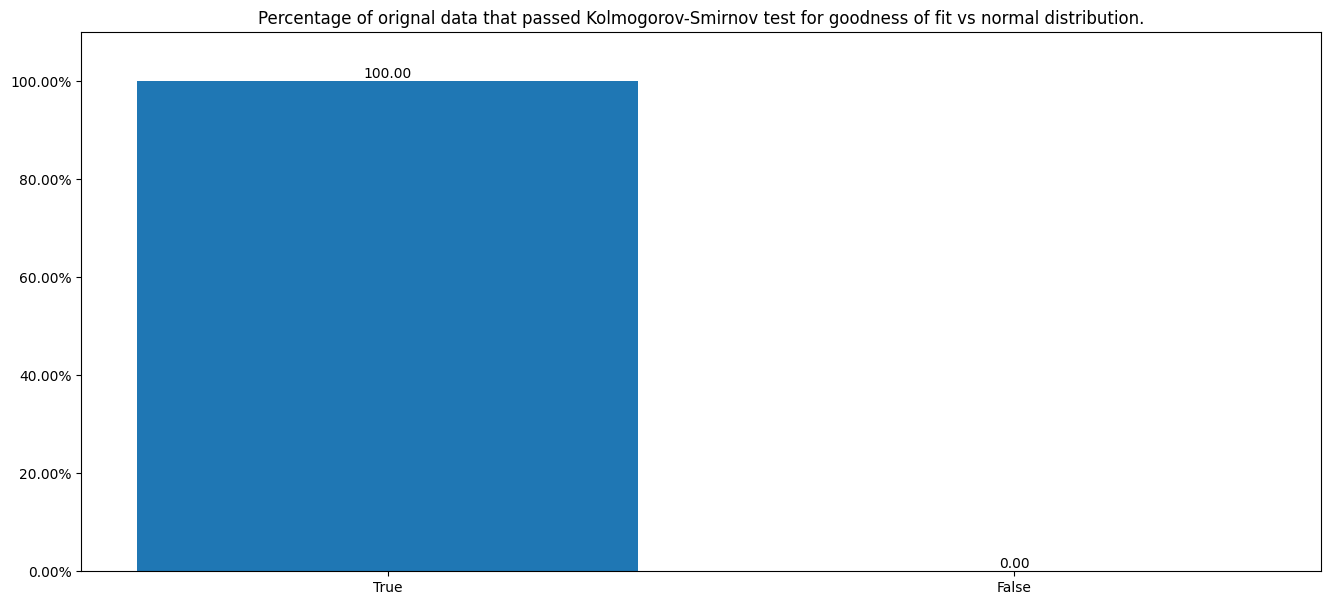

In [26]:
plot_ks_comparison(
    kstest_values,
    "Percentage of orignal data that passed Kolmogorov-Smirnov test for goodness of fit vs normal distribution.",
)